In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import itertools
import joblib

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Make scorers from custom scoring functions
mape = make_scorer(mape_scorer, greater_is_better=False)  # Since we want to minimize MAPE

# Custom TqdmRandomizedSearchCV class
class TqdmRandomizedSearchCV(RandomizedSearchCV):
    def __init__(self, estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None,
                 refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs',
                 random_state=None, error_score=np.nan, return_train_score=False):
        super().__init__(
            estimator=estimator, param_distributions=param_distributions, n_iter=n_iter,
            scoring=scoring, n_jobs=n_jobs, refit=refit, cv=cv, verbose=verbose,
            pre_dispatch=pre_dispatch, random_state=random_state, error_score=error_score,
            return_train_score=return_train_score)
        
    def fit(self, X, y, **fit_params):
        with tqdm(total=self.n_iter, desc="RandomizedSearchCV Progress") as self._tqdm:
            return super().fit(X, y, **fit_params, scoring=self.scoring)

    def _run_search(self, evaluate_candidates):
        """ Use tqdm with RandomizedSearchCV """
        super()._run_search(evaluate_candidates)

        
    def fit(self, X, y, **fit_params):
        with tqdm(total=self.n_iter, desc="RandomizedSearchCV Progress") as self._tqdm:
            return super().fit(X, y, **fit_params)

    def _run_search(self, evaluate_candidates):
        """ Use tqdm with RandomizedSearchCV """
        super()._run_search(evaluate_candidates)
        
# Load the dataset
df_raw = pd.read_csv('Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the TqdmRandomizedSearchCV object
random_search = TqdmRandomizedSearchCV(
    estimator=xgboost_model, 
    param_distributions=param_distributions, 
    n_iter=100,  # Number of parameter settings that are sampled
    scoring=scoring, 
    refit='RMSE',  # Refit an estimator using the best found parameters on the whole dataset
    cv=3, 
    verbose=1,
    random_state=42
)

# Fit the random search to the scaled training data
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_parameters = random_search.best_params_

# Print the best parameters
print(f"Best parameters found: {best_parameters}")

# Train the best model on the scaled training data
best_model = random_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Predict on the scaled test set with the best model
y_pred = best_model.predict(X_test_scaled)

# Calculate the metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape_score = mape_scorer(y_test, y_pred)

# Calculate the range of traffic_volume
traffic_volume_range = df[target].max() - df[target].min()

# Normalize RMSE and MAE
normalized_rmse = rmse / traffic_volume_range
normalized_mae = mae / traffic_volume_range

# Output the metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized Root Mean Squared Error (RMSE): {normalized_rmse}")
print(f"Normalized Mean Absolute Error (MAE): {normalized_mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_score}%")
print(f"R-squared (R2): {r2}")

# Save the best model and the scaler for later use
best_model.save_model('best_xgboost_model.json')
joblib.dump(scaler, 'scaler.save')


NameError: name 'scoring' is not defined

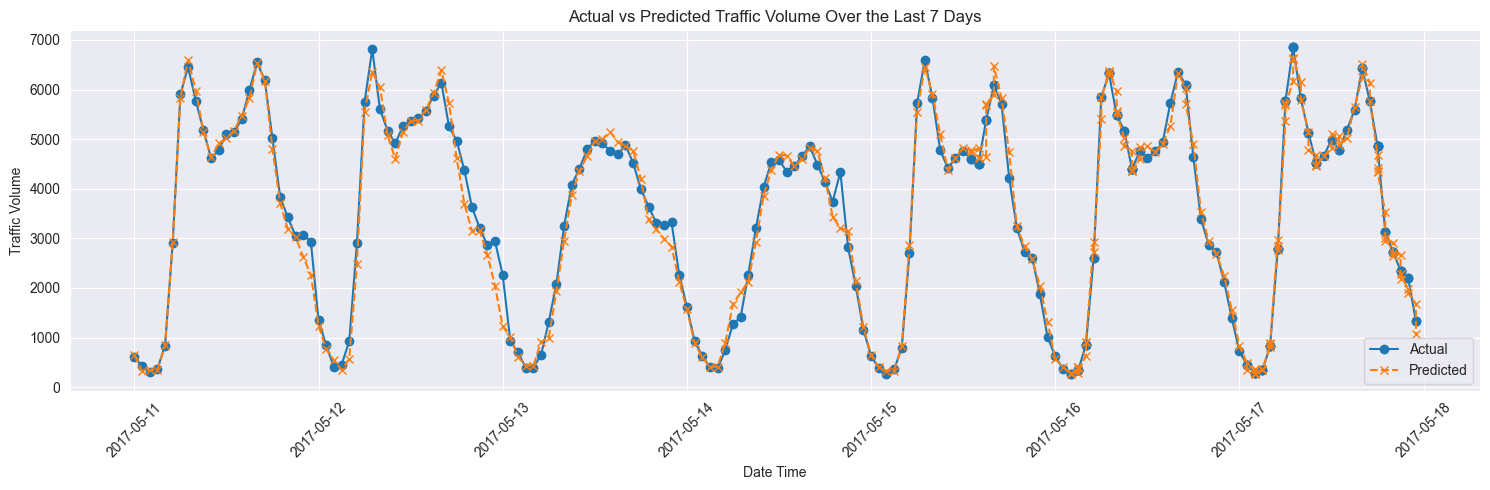

In [2]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined and are pandas Series
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_df['date_time'] = y_test.index  # Assuming y_test still has the date_time index
comparison_df.set_index('date_time', inplace=True)

# Select the last 7 days of data for plotting
last_7_days = comparison_df.last('7D')  # '7D' for 7 days

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(last_7_days['Actual'], label='Actual', marker='o')
plt.plot(last_7_days['Predicted'], label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs Predicted Traffic Volume Over the Last 7 Days')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()
